In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import pickle


2022-06-27 10:48:51.609769: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 10:48:51.615182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 10:48:51.615198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
boosted_model =  tf.keras.models.load_model('../pb_file')

boosted_model.summary()


2022-06-27 10:48:56.885564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-27 10:48:56.885611: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 10:48:56.885643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-06-27 10:48:56.886177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [3]:
# settings of the networks 
output = 1

nbr_batch =64
nbr_epoch = 200
lr=0.001

delta= 0.00000001


nbr_conv_epoch = 4 #number of epochs for the conversion 
patience_es = 12

patience_rlr0 = 3
patience_rlr1 = 5


def units(j): return (j+8)
units_range = 1

def version(v): return v
versions_range = 10

In [4]:
#quantized settings
integer = 0


def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+2)*2

def bit_width(i): return {'bits': (i+2)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 7

In [5]:
# path
def qmodels_path(i): return f"tests/qmodels/qmodels_epoch{nbr_conv_epoch},rkernel<{bit_lenghts(i)},{integer}>,rest10.h5"
def qhist_path(i): return f"tests/qhist/qmodels_epoch{nbr_conv_epoch},rkernel<{bit_lenghts(i)},{integer}>,rest10.pkl"
def qpredicts_path(i): return f"tests/qpredicts/qmodels_epoch{nbr_conv_epoch},rkernel<{bit_lenghts(i)},{integer}>,rest10.pkl"

#path of the tested models 
def models_path0(v) : return f"tests/models/models_patiencES={patience_es}_patienceRLR={patience_rlr0}_mindelta{delta}_v{version(v)}.h5"
def predicts_path0(v) : return f"tests/predicts/models_patiencES={patience_es}_patienceRLR={patience_rlr0}_mindelta{delta}_v{version(v)}.npy"
def hists_path0(v) : return f"tests/hist/models_patiencES={patience_es}_patienceRLR={patience_rlr0}_mindelta{delta}_v{version(v)}.pkl"

def models_path1(v) : return f"tests/models/models_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta}_v{version(v)}.h5"
def predicts_path1(v) : return f"tests/predicts/models_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta}_v{version(v)}.npy"
def hists_path1(v) : return f"tests/hist/models_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta}_v{version(v)}.pkl"


def qmodels_path(i): return f"tests/qmodels/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest10.h5"
def qpredicts_path(i): return f"tests/qpredicts/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest10.npy"

#path of the qconverted models
def qhist_path(i): return f"tests/qhist/qmodels_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>,rest10.pkl"

refmodels_path = f"tests/models/models_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta}_v4.h5"      
refpredicts_path = f"tests/predicts/models_patiencES={patience_es}_patienceRLR={patience_rlr1}_mindelta{delta}_v4.npy"      




In [6]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

xref, xref_val, xref_test, yref, yref_val, yref_test = ds()


shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [7]:
def exist(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test))
     
    else : print(f'{path} already exists')
def exist_std(path,modeltopred):
    cut_indices = np.where(y_test > 0.24/16)[0]
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test[cut_indices]))
     
    else : print(f'{path} already exists')

In [8]:
def exist(path, modeltopred):

    if (os.path.exists(path)==False):
        print(path)
        print('saving')
        np.save(path, modeltopred.predict([X_test_past, X_test]))
        print('saved')
    else : print(f'{path} already exists')

In [9]:
ref_path = 'tests/ref_predicts.npy'
exist(ref_path, boosted_model)

tests/ref_predicts.npy already exists


In [10]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

X, X_valid, X_test, y, y_valid, y_test = ds(seq_len=30)

X_past = X[:,:25,:]
X_valid_past = X_valid[:,:25,:]
X_test_past = X_test[:,:25,:]

X = X[:,25:,:]
X_valid = X_valid[:,25:,:]
X_test = X_test[:,25:,:]

shapes (1999970, 30, 1) (1999970, 1)
shapes (899956, 30, 1) (99969, 30, 1) (999985, 30, 1)


In [11]:
print(1999970*0.5)

999985.0


In [12]:
model = tf.keras.models.load_model(models_path1(4))
print(mse(y_test, model.predict([X_test_past, X_test])))

31250/31250 [==============================] - 39s 1ms/step
7.937658e-06


In [13]:
for v in range (versions_range):

    model0 = tf.keras.models.load_model(models_path0(v))
    exist(predicts_path0(v), model0)


    model1 = tf.keras.models.load_model(models_path1(v))
    exist(predicts_path1(v), model1)

    """model2 = tf.keras.models.load_model(models_path2(v))
    exist(predicts_path2(v), model2)    
   
    model3 = tf.keras.models.load_model(models_path3(v))
    exist(predicts_path3(v), model3)

    model4 = tf.keras.models.load_model(models_path4(v))
    exist(predicts_path4(v), model4)

    model5 = tf.keras.models.load_model(models_path5(v))
    exist(predicts_path5(v), model5)"""
    

tests/predicts/models_patiencES=12_patienceRLR=3_mindelta1e-08_v0.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=5_mindelta1e-08_v0.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=3_mindelta1e-08_v1.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=5_mindelta1e-08_v1.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=3_mindelta1e-08_v2.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=5_mindelta1e-08_v2.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=3_mindelta1e-08_v3.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=5_mindelta1e-08_v3.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=3_mindelta1e-08_v4.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=5_mindelta1e-08_v4.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=3_mindelta1e-08_v5.npy already exists
tests/predicts/models_patiencES=12_patienceRLR=5_mindelta1e-08_v5

In [45]:
import ROOT
from ROOT import TCanvas, TColor, TGaxis, TH1D, TPad, TLegend, TLatex, TH2D, TF1, TLine
from ROOT import kBlack, kBlue, kRed, kGreen, kMagenta
%jsroot off

In [2]:
def get_gap_to_previous(sequence, threshold=0.24):

    gap = np.zeros_like(sequence)
    dist_to_prev = 0

    for i in range(0, len(sequence)):
        dist_to_prev += 1
        gap[i] = dist_to_prev

        if sequence[i] > threshold:
            dist_to_prev = 0
    return gap

In [4]:
gap_for_testset=get_gap_to_previous(ds.hit)[-999985:]
print(gap_for_testset.shape)
print(y_test.shape)


NameError: name 'ds' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: histogram1 (Potential memory leak).


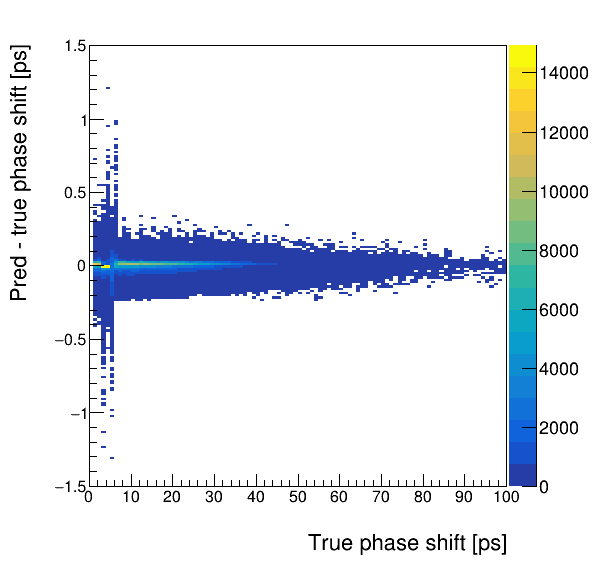

In [54]:

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

# Select events with >240MeV
ECUT = 0.24

inds = np.where((y_test[:,0] ))#> ECUT/16))[0]

# Model predictions in array
model_predictions = np.load(predicts_path1(4))


c = TCanvas("c", "c", 600, 600)
c.cd();
c.SetBottomMargin(0.15)
c.SetTopMargin(0.08)
c.SetLeftMargin(0.15)
c.SetRightMargin(0.15)

h1 = TH2D("histogram1", "histogram2", 100, 0, 100, 200, -1.5 ,1.5)
h1.Sumw2()
denorm=16
prof1 = h1.ProfileX("p1", 1, -1, "s")
prof1.Draw("HIST E3")


for x, y in zip(gap_for_testset[inds], model_predictions[inds]-y_test[inds]):
    h1.Fill(x, y*denorm)

h1.GetYaxis().SetTitleFont(43)
h1.GetXaxis().SetTitleFont(43)
h1.GetYaxis().SetTitleOffset(1.55)

h1.SetStats(0)

h1.GetYaxis().SetTitle("Pred - true phase shift [ps]")#"##splitline{One entry per network}{[normalized to unity]}")#"Normalized to unity")
h1.GetXaxis().SetTitle("True phase shift [ps]")#f"{xtitle} of E^{{T}}_{{pred}} - E^{{T}}_{{true}} [GeV]")
#h1.GetYaxis().SetRangeUser(0,0.45)
#h1.GetXaxis().SetRangeUser(0, 0.5)

#SetLabelSize(0.05)
h1.GetXaxis().SetLabelSize(0.03)
h1.GetYaxis().SetLabelSize(0.03)

h1.GetYaxis().SetTitleOffset(1.8)
h1.GetXaxis().SetTitleOffset(1.5)


h1.GetXaxis().SetTitleSize(24)
h1.GetYaxis().SetTitleSize(24)




h1.Draw("colz")




l = TLatex() 
l.SetTextSize(18)
l.SetTextFont(42)
l.SetTitle("title")
l.SetNDC()
l.SetTextColor(kBlack)
l.DrawLatex(0.5, 0.5, "some text: E^{{T}}_{{true}} > 1 GeV")

c.Draw()





In [17]:

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

# Select events with >240MeV
ECUT = 0.24

inds = np.where((y_test[:,0] ))#> ECUT/16))[0]

# Model predictions in array
model_predictions = np.load(predicts_path1(0))


c = TCanvas("c", "c", 600, 600)
c.cd();
c.SetBottomMargin(0.15)
c.SetTopMargin(0.08)
c.SetLeftMargin(0.15)
c.SetRightMargin(0.15)
c.SetLogx()

h1 = TH2D("histogram1", "histogram2", 100, 0, 5, 200, -2 ,2)
h1.Sumw2()
denorm=16
prof1 = h1.ProfileX("p1", 1, -1, "s")
prof1.Draw("HIST E3")


for x, y in zip(y_test[inds], model_predictions[inds]):
    h1.Fill(x*denorm, (y-x)*denorm)

h1.GetYaxis().SetTitleFont(43)
h1.GetXaxis().SetTitleFont(43)
h1.GetYaxis().SetTitleOffset(1.55)

h1.SetStats(0)

h1.GetYaxis().SetTitle("Pred - true phase shift [ps]")#"##splitline{One entry per network}{[normalized to unity]}")#"Normalized to unity")
h1.GetXaxis().SetTitle("True phase shift [ps]")#f"{xtitle} of E^{{T}}_{{pred}} - E^{{T}}_{{true}} [GeV]")
#h1.GetYaxis().SetRangeUser(0,0.45)
#h1.GetXaxis().SetRangeUser(0, 0.5)

#SetLabelSize(0.05)
h1.GetXaxis().SetLabelSize(0.03)
h1.GetYaxis().SetLabelSize(0.03)

h1.GetYaxis().SetTitleOffset(1.8)
h1.GetXaxis().SetTitleOffset(1.5)


h1.GetXaxis().SetTitleSize(24)
h1.GetYaxis().SetTitleSize(24)




h1.Draw("colz")




l = TLatex() 
l.SetTextSize(18)
l.SetTextFont(42)
l.SetTitle("title")
l.SetNDC()
l.SetTextColor(kBlack)
l.DrawLatex(0.5, 0.5, "some text: E^{{T}}_{{true}} > 1 GeV")

c.Draw()





Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: histogram1 (Potential memory leak).


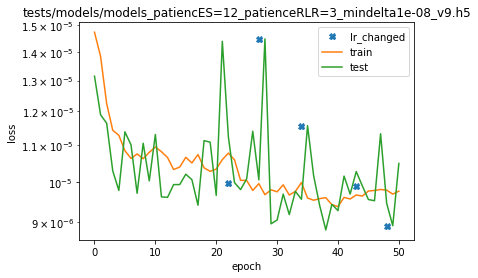

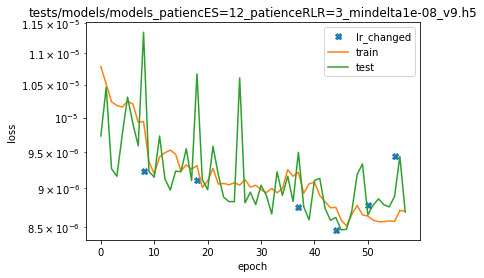

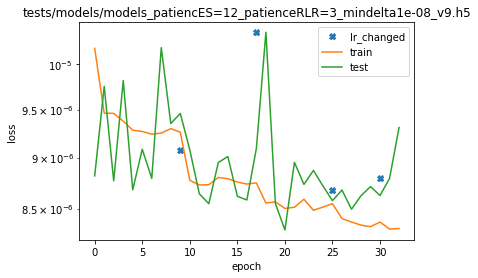

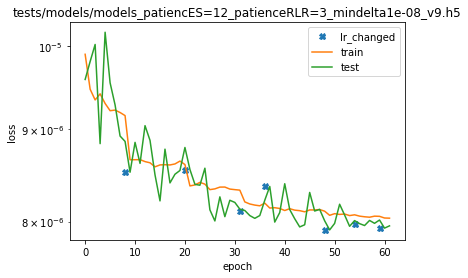

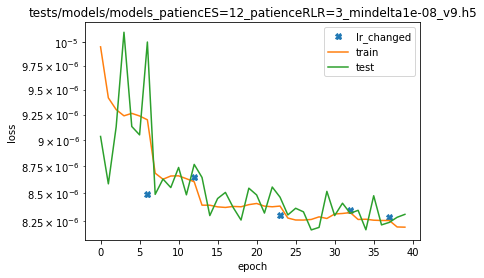

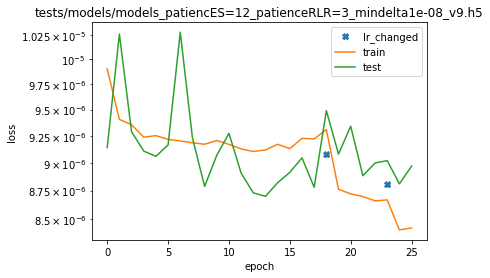

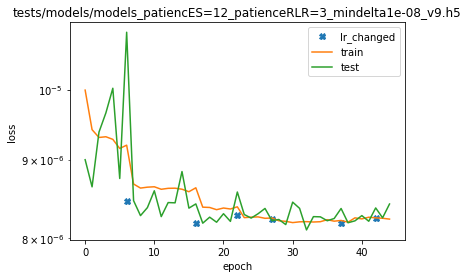

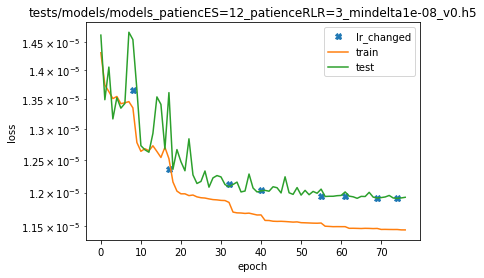

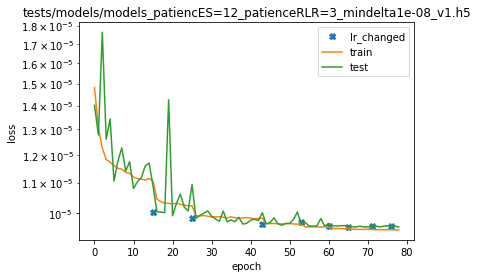

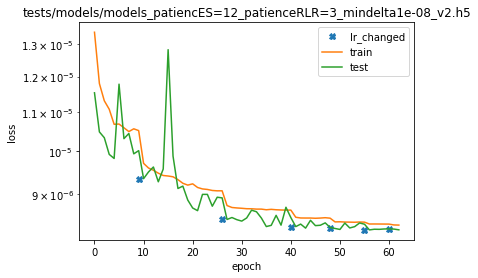

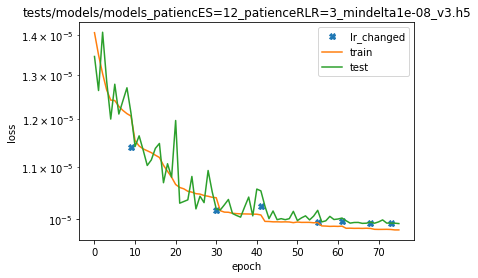

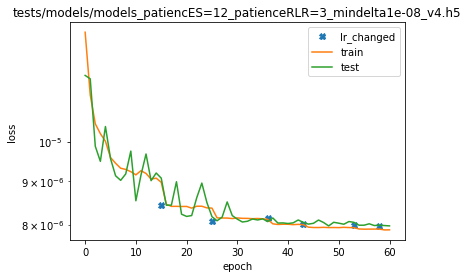

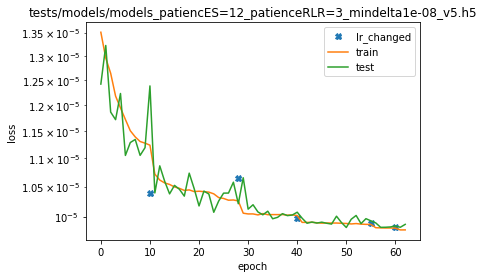

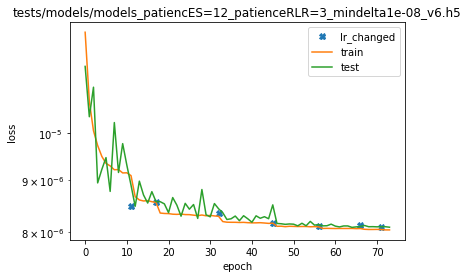

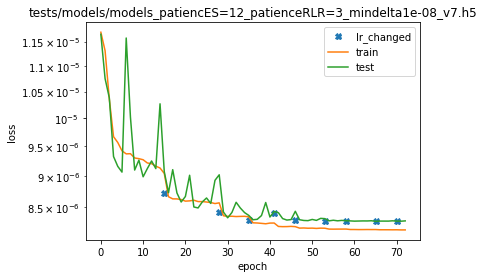

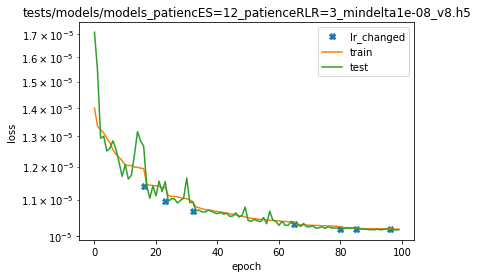

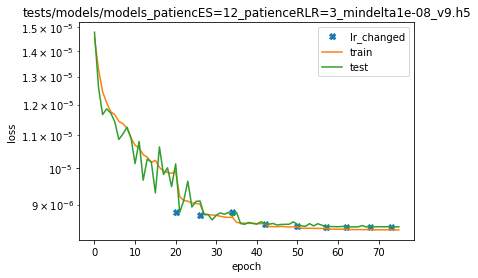

In [16]:

for i in range (bits_range):

    
    file_to_read = open(qhist_path(i),"rb")
    hist = pickle.load(file_to_read)
    lr_change = []
    for a in range (len(hist['lr'])-1):

        if (hist['lr'][a]==hist['lr'][a+1]):
            lr_change.append(None)
        else: 
            lr_change.append(hist['val_loss'][a+1])
    plt.plot(lr_change, 'X')
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title(models_path0(v))
    plt.yscale('log')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['lr_changed','train', 'test'])
    plt.show()

    
for v in range (versions_range):

    
    file_to_read = open(hists_path1(v),"rb")
    hist = pickle.load(file_to_read)
    lr_change = []
    for a in range (len(hist['lr'])-1):

        if (hist['lr'][a]==hist['lr'][a+1]):
            lr_change.append(None)
        else: 
            lr_change.append(hist['val_loss'][a+1])
    plt.plot(lr_change, 'X')
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title(models_path0(v))
    plt.yscale('log')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['lr_changed','train', 'test'])
    plt.show()

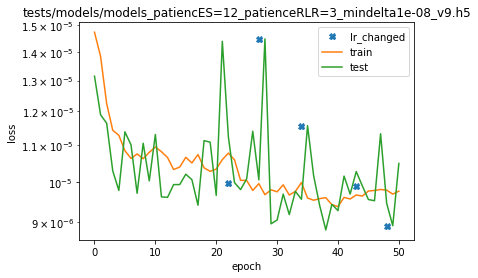

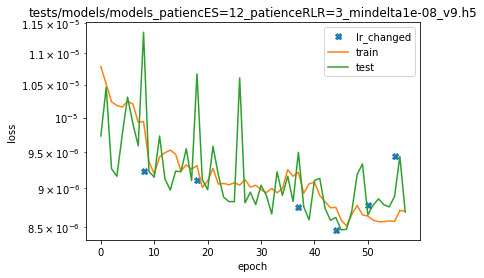

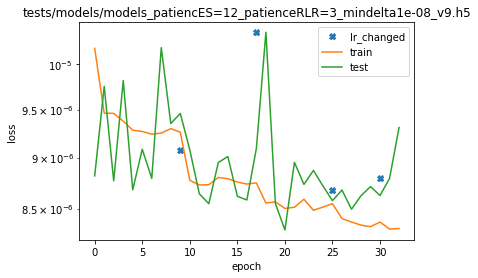

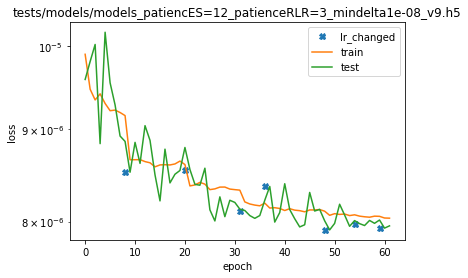

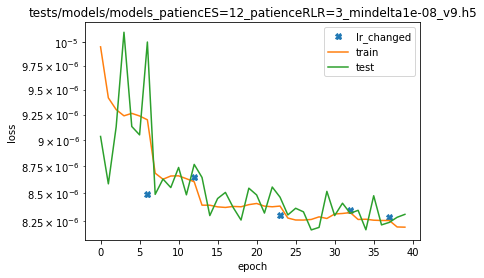

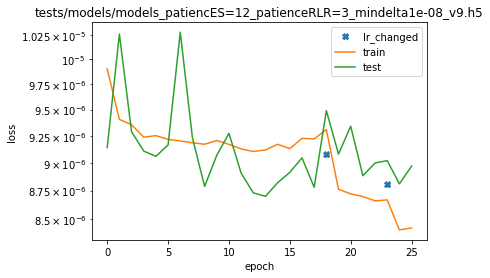

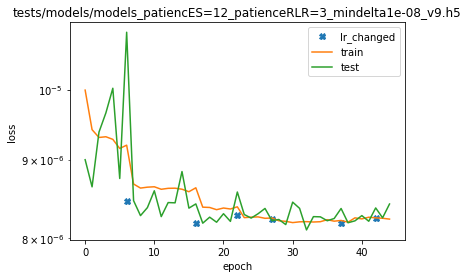

In [19]:
    
for i in range (bits_range):
    file_to_read = open(qhist_path(i),"rb")
    hist = pickle.load(file_to_read)
    lr_change = []
    for a in range (len(hist['lr'])-1):

        if (hist['lr'][a]==hist['lr'][a+1]):
            lr_change.append(None)
        else: 
            lr_change.append(hist['val_loss'][a+1])
    plt.plot(lr_change, 'X')
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title(models_path0(v))
    plt.yscale('log')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['lr_changed','train', 'test'])
    plt.show()